In [1]:
# error
# transforms.Normalize((0.5,), (0.5,))
# (1, 28, 28)

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# transform = simply dictates any image manipulations that you wish to apply on your images
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [5]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

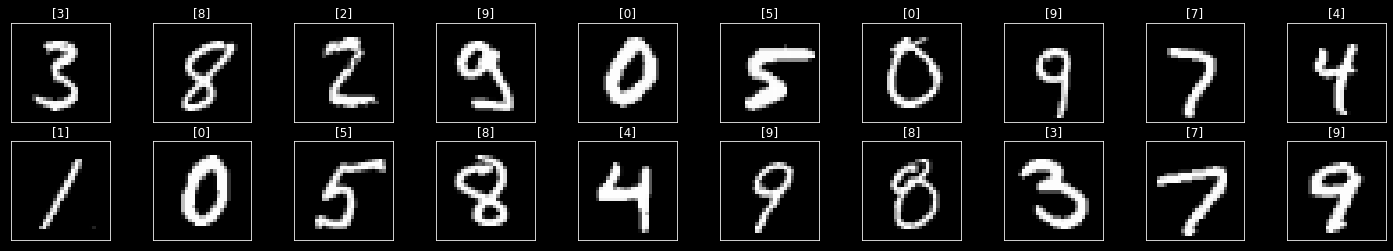

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500) # 28x28 -> 24x24 -> 12x12 -> 8x8 -> 4x4
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch : ', (e+1))
        print('training loss: {:.4f}, training acc : {:.4f}'.format(epoch_loss, epoch_acc))
        print('validation loss: {:.4f}, validation acc : {:.4f}'.format(val_epoch_loss, val_epoch_acc))
        

epoch :  1
training loss: 0.1831, training acc : 94.4100
validation loss: 12.5888, validation acc : 98.2100
epoch :  2
training loss: 0.0538, training acc : 98.3617
validation loss: 13.2572, validation acc : 98.8500
epoch :  3
training loss: 0.0386, training acc : 98.7917
validation loss: 16.2524, validation acc : 98.2500
epoch :  4
training loss: 0.0308, training acc : 99.0100
validation loss: 16.5398, validation acc : 99.0900
epoch :  5
training loss: 0.0255, training acc : 99.1950
validation loss: 19.1465, validation acc : 99.0400
epoch :  6
training loss: 0.0215, training acc : 99.3450
validation loss: 20.2964, validation acc : 98.9400
epoch :  7
training loss: 0.0183, training acc : 99.4233
validation loss: 21.1570, validation acc : 98.9800
epoch :  8
training loss: 0.0166, training acc : 99.4733
validation loss: 23.1406, validation acc : 98.9500
epoch :  9
training loss: 0.0152, training acc : 99.4767
validation loss: 22.4743, validation acc : 98.9800
epoch :  10
training loss: 0

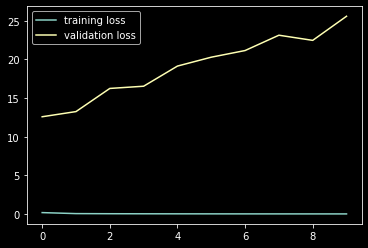

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

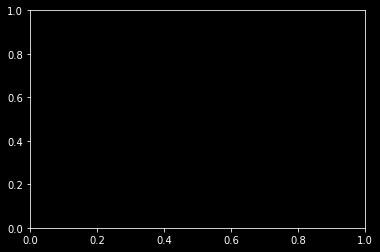

In [12]:
plt.plot(running_corrects_history, label="training_accuracy")
plt.plot(val_running_corrects_history, label="validation_accuracy")
plt.legend()

<Response [200]>


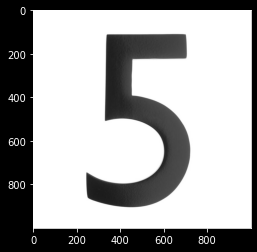

In [13]:
import requests
from PIL import Image
import PIL
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

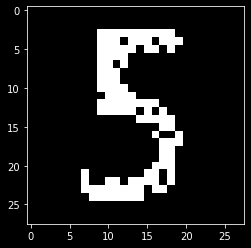

In [14]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [15]:
images = img.to(device)
images =images[0].unsqueeze(0).unsqueeze(0)
output = model(images)
_, pred = torch.max(output, 1)
print(pred.item())

5


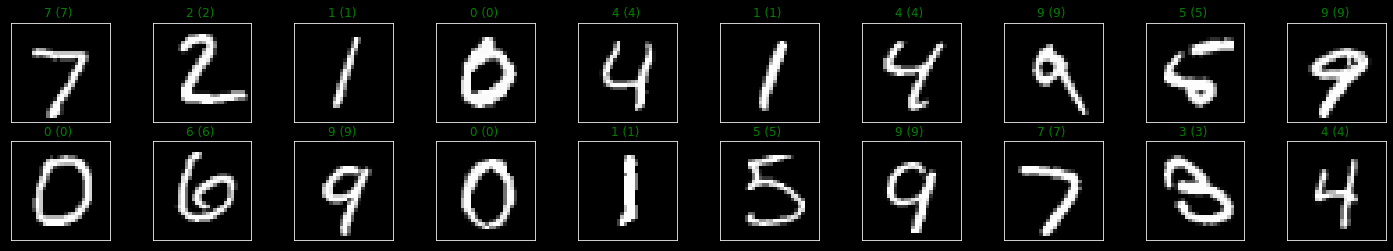

In [16]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({}) ".format(str(preds[idx].item()), str(labels[idx].item())), color = ('green' if preds[idx] == labels[idx] else 'red'))